## Confguration Space

In this notebook we will create a configuration space given a map of the world and a particular altitude for our drone.

The map is given in a `.csv` file, which contains obstacle data. The first line of the file gives the map center coordinates ([and this is here)](https://www.google.com/maps/place/37°47'32.9%22N+122°23'50.8%22W/@37.7924566,-122.4018247,16z/data=!4m5!3m4!1s0x0:0xc1332062f3ed759d!8m2!3d37.79248!4d-122.39745). The rest of the file is arranged in six columns $x$, $y$, $z$ and $\delta x$, $\delta y$, $\delta z$ such that:

* $x$ -> NORTH
* $y$ -> EAST
* $z$ -> ALTITUDE (positive up, note the difference with NED coords)

Each $(x, y, z)$ coordinate is the center of an obstacle. $\delta x$, $\delta y$, $\delta z$ are the half widths of the obstacles, meaning for example that an obstacle with $(x = 37, y = 12, z = 8)$ and $(\delta x = 5, \delta y = 5, \delta z = 8)$ is a 10 x 10 m obstacle that is 16 m high and is centered at the point $(x, y) = (37, 12)$ at a height of 8 m.

Given a map like this, the free space in the $(x, y)$ plane is a function of altitude, and we can plan a path around an obstacle, or simply fly over it!

We will extend each obstacle by a safety margin to create the equivalent of a 3 dimensional configuration space. 

The task is to extract a 2D grid map at 1 metre resolution of the configuration space for a particular altitude, where each value is assigned either a 0 or 1 representing feasible or infeasible (obstacle) spaces respectively.

The end result should look something like this ... (colours aren't important)

![title](grid_map.png)

In [200]:
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = [12, 12]

Read the csv file which contains the coordinates of the obstacles. 

In [201]:
filename = 'colliders.csv'
# Read in the data skipping the first two lines.  
# Note: the first line contains the latitude and longitude of map center
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


The given function will take the data from the file describing the obstacles city and will return a 2D grid representation showing open and closed spaces.

In [202]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))   #np.floor = rounding to lower integer (-2.3 --> -3)
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))    #np.ceil = rounding to upper integer (-2.3 --> -2)

    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))
    
    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        if drone_altitude <= (alt + d_alt + safety_distance):
            obst = [int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                    int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                    int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                    int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1))]
            
            grid[obst[0]:obst[1]+1, obst[2]:obst[3]+1] = 1

    return grid

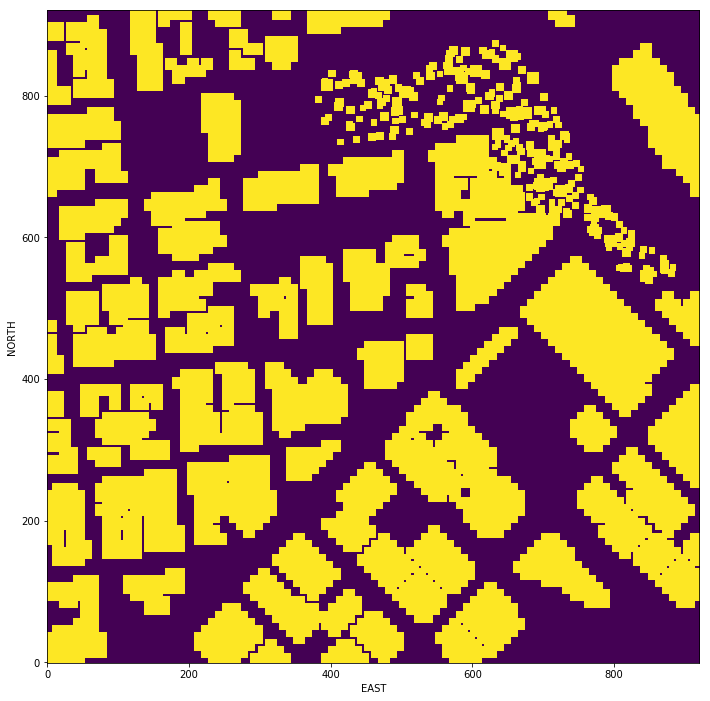

In [203]:
# Static drone altitude (metres)
drone_altitude = 10

# Minimum distance required to stay away from an obstacle (metres)
# Think of this as padding around the obstacles.
safe_distance = 3

# Creation of configuration spacee at the indicated drone_altitude and safe_distance
grid = create_grid(data, drone_altitude, safe_distance)

# Plotting the grid
# NOTE we are placing the origin in the lower lefthand corner so that north is up
plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Play around with the drone_altitude and safe_distance values to get a feel for how it changes the map.